# <u>**Project - Data Science**<u>

<br>

|Group Members|
|---|
|Omar Ennouri|
|Khouloud Gharbi|
|Bruno Colque|
|Mohamed Amine Mroua|
|Mahdi Ghamgui|



# **Deliverable 3 - Image Captioning**


This deliverable addresses the final phase of a project aimed at creating a neural network model capable of automatically generating captions for images using the MS COCO dataset. The model combines several advanced techniques to effectively capture visual features and generate textual captions. It consists of three main parts: a CNN, an RNN, and an attention mechanism.

1. CNN (Convolutional Neural Network) – Image Encoding
The CNN is used to extract rich visual features from the images. In this project, a pre-trained model like Inception V3 and DenseNet will be used to encode each image into a compressed vector representation. This reduces dimensionality while retaining important visual information.

Theory: A CNN is designed to capture spatial patterns in an image, moving from shallow convolutional layers (detecting edges and textures) to deeper layers that capture more complex shapes. For this project, the outputs from an intermediate layer of the model are used as the image representation.

2. RNN (Recurrent Neural Network) – Caption Generation
The RNN (typically an LSTM or GRU in this case) uses the features extracted by the CNN to sequentially generate a caption word by word. The model predicts each word based on the image representation and the previously generated words.

Theory: RNNs are suited for processing sequences, such as sentences, as they maintain a memory of past states through their internal loops. LSTM and GRU, being advanced variants of RNNs, are particularly effective at handling long and complex sequences by mitigating the issues of vanishing gradients.

3. Attention Mechanism – Focusing on Important Regions
The attention mechanism is added to allow the model to focus on specific parts of the image when generating each word of the caption. Instead of processing the entire image representation at each step of the sequence, the model dynamically weighs different regions of the image based on the word it is generating.

Theory: Attention enables the model to "look" at different parts of the image at each caption generation step, assigning higher weights to regions relevant to the word being predicted. This improves the accuracy of the captions, as the model can adjust its focus based on context.

![Prediction](https://tensorflow.org/images/imcap_prediction.png)

**Importing Libraries for Image Processing, Data Management, and Caption Generation Model Construction**

In this section, we will import the essential libraries required for efficiently processing images, managing data, and constructing our neural network model for automatic caption generation. The selection of libraries is critical to ensure that our implementation is robust and leverages existing tools optimized for deep learning tasks.

In [ ]:
import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image
import glob
import cv2
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [ ]:
    annotation_file = os.path.abspath('.')+"/annotations/captions_train2014.json"
    X_data = []
    img_height, img_width = 300, 300
    batch_size = 128
    files = glob.glob("/train2014")

    for myFile in files:
        image = cv2.imread(myFile)
        image_RGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_resized = cv2.resize(image_RGB, (img_width, img_height))
        X_data.append(image_resized)

X_data shape: (0,)


**Explanation: Limitation on the Size of Our Training Dataset**

To reduce the computational power required for training our model, we have chosen to work with a subset of 30,000 captions. While adding more data could enhance the quality of the generated captions, our current hardware resources are not sufficiently powerful to allow for an increase in the size of our training dataset.

In [ ]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)
PATH = os.path.abspath('C:\\Users\\gu\\annotations\\train20142\\train2014\\COCO_train2014_')

In [ ]:
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [ ]:

image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)
# Sélection des 6000 premières images du jeu de données aléatoire
# Chaque image à environ 5 sous-titres qui lui sont associés, cela équivaut
# donc à 30,000 sous-titres différents.
train_image_paths = image_paths[:6000]
print(len(train_image_paths))


6000


This code combines the captions associated with the images with the paths of the images into two distinct lists, train_captions and img_name_vector.

In [ ]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

<start> A picture of the feet of lacrosse players at a game. <end>


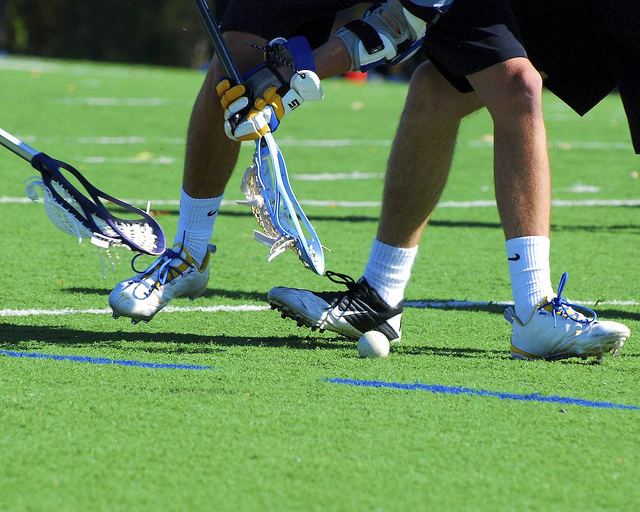

In [ ]:
print(train_captions[0])
Image.open(img_name_vector[0])

**CNN (inceptionv3) and RNN (GRU)**

**Image Preprocessing with InceptionV3**

In this section, we will proceed with acquiring the InceptionV3 model, which has been pre-trained on the ImageNet dataset. The goal is to classify each image by extracting essential features from the model's last convolutional layer. InceptionV3 is particularly suited for this task due to its complex architecture, which combines several types of filters within a single layer. This allows the model to capture a wide variety of features at different scales, making the classification process more efficient.

**Steps for Image Preprocessing**
To ensure that the images are compatible with the requirements of InceptionV3, we will perform the following steps:

**Image Resizing:**
The images must be resized to a size of
299
×
299
299×299 pixels. This is required by the model, as InceptionV3 has been designed to work with inputs of this dimension. Resizing preserves the structure of the data while ensuring that all input images have the same dimensions, which is crucial for neural networks.

**Normalization of Pixel Values:**
We will use the preprocess_input function provided by Keras to normalize the pixel values. This step involves adjusting the pixel values from a scale of 0 to 255 to a range of -1 to 1. Normalization is essential for the proper functioning of the model, as it helps accelerate convergence during training. By bringing the values into a smaller range, we reduce the variance between different inputs, which helps the model learn more effectively.

Expected Outcomes
After preprocessing the images, we expect to:

Enhance Model Performance:
Normalization and resizing will ensure that the InceptionV3 model operates optimally. By using a model pre-trained on ImageNet, we can also leverage the knowledge it has acquired during training on a wide range of images.

Extract Reliable Features:
By extracting features from the last convolutional layer, we will obtain rich and informative feature vectors that effectively represent each image. These vectors can then be used for various classification or image analysis tasks.

Reduce Training Time:
Thanks to the use of a pre-trained model and data normalization, we anticipate a significant reduction in the time required to train our model on our specific dataset, as the model will have already learned useful feature representations.

The preprocessing of images with InceptionV3 is a crucial step that directly influences the model's performance and the quality of the results obtained during image classification.

**InceptionV3 Images loading**

In [ ]:
def load_image(image_path):

    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

**Initialization of InceptionV3 and Loading Pre-Trained ImageNet Weights**

In this step, we will initialize a tf.keras model using the InceptionV3 architecture. We will configure the model so that the output layer is the last convolutional layer, which produces an output shape of
8
×
8
×
2048
8×8×2048. This dimension indicates that after processing the image, the model provides a tensor containing 2048 features extracted from an
8
×
8
8×8 grid.

*Why Choose the Last Convolutional Layer?*
Selecting the last convolutional layer is essential for several reasons:

*Rich Feature Representation*: The last convolutional layer of InceptionV3 captures complex and abstract information about the image, representing high-level visual elements that are crucial for tasks such as attention-based captioning. These features are abstractions of elements like textures, shapes, and objects present in the image.

*Effective Use of Attention*: In attention-based captioning models, it is vital to work with features that allow for better contextualization of the image. The outputs from this layer facilitate the learning of a robust contextual representation, essential for generating accurate descriptions of images.

*Image Processing Workflow*
Routing Images Through the Network: Each image in our dataset is passed through the InceptionV3 network. The model processes the images and generates feature vectors that capture the essential information present in each image.

*Storing Feature Vectors*: For each processed image, we store the corresponding feature vector in a dictionary in the form (image_name --> feature_vector). This allows us to structurally associate each image with its unique feature vector.

*Saving the Data*: Once all the images have been processed and their feature vectors extracted, we save this dictionary to disk. This operation is crucial for later use, as it enables quick access to the feature vectors without having to reprocess the images each time.

**Expected Outcomes**

At the end of this process, we expect to:

Obtain a Complete Dictionary: This dictionary will contain the feature vectors for all images, ready to be used for classification tasks, captioning, or other analyses.

Improve Efficiency: By saving the feature vectors to disk, we optimize processing time for subsequent steps of our project, as we will avoid recalculating features on each run.

In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer);

**Feature Extraction with InceptionV3**

We preprocess each image using InceptionV3 and cache the output. Caching in RAM is fast, but it comes with a high memory cost, as it requires storing
8
×
8
×
2048
8×8×2048 floating-point values per image. However, we have no other option, as Kaggle does not allow saving files.

Performance can be improved by using a more sophisticated caching strategy, such as fragmenting images to reduce random I/O access on disk. However, this approach would require more complex code.



In [ ]:
# Récupération d'images uniques
encode_train = sorted(set(img_name_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)
np_images={}
for img, path in image_dataset:
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np_images[path_of_feature]=bf.numpy()

**Preprocessing and Tokenization of Captions**

The process of preprocessing and tokenizing captions is a crucial step in preparing data for training natural language processing (NLP) models. This process occurs in several stages, each aimed at structuring the captions in a way that facilitates their use in the model.

**Steps in Preprocessing and Tokenization**

Tokenization of Captions
The first step involves tokenizing the captions by separating words. This operation can be performed using spaces as delimiters. For example, a caption like "A man is surfing on a wave" will be transformed into a list of tokens: ["A", "man", "is", "surfing", "on", "a", "wave"]. This allows for the creation of a vocabulary that includes each unique word present in the data, such as "surfing," "football," etc.

**Limiting Vocabulary Size**

To optimize memory usage and improve efficiency, we impose a restriction on vocabulary size by retaining only the 5,000 most frequently used words. Words outside of this limit are replaced by the token "UNK" (short for "unknown"). This approach ensures that the model focuses on the most relevant words while treating rare words uniformly.

**Creating Bidirectional Mappings**

We create bidirectional mappings between words and their indices, which includes:

Word to Index Mapping: Each word in the vocabulary is associated with a unique index, allowing for numerical representation of each word.
Index to Word Mapping: This mapping allows for easy retrieval of the original word from its index, thereby facilitating the interpretation of the model's results.

**Padding Word Sequences**

To ensure consistency of inputs during training, we pad all word sequences to match the length of the longest sequence. This is accomplished by padding shorter sequences with a special token (typically 0 or another number) to align them with the desired length. This step facilitates processing by the model, as neural networks require uniform input sizes.

**Expected Outcomes**

At the end of this preprocessing and tokenization process, we expect to achieve:

Optimized Vocabulary: A compact and efficient vocabulary of the most commonly used words, facilitating the model's learning process.

Numerical Representation of Captions: Captions converted into a numerical format, ready to be used as inputs for the model.

Input Consistency: Uniform-length sequences, simplifying processing and learning by the model.

In [ ]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

# Max word count for a caption.
max_length = 50
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

# Create the tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

# Create mappings for words to indices and indicies to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)


**Data Partitioning into Training and Validation Sets**

In this step, we randomly divide our dataset into two sets. We opted for a 80% - 20% split, which corresponds to 24,000 images for the training set and 6,000 images for the validation set.

In [ ]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

# Création des jeux d'entraînement et de validation, en utilisant une séparation 80-20 aléatoirement.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []

for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24014, 24014, 6004, 6004)

**Creating a tf.data Dataset for Training**

Our images and captions are ready, and we can now create a tf.data dataset to facilitate and optimize the training process of our model. We will configure the parameters of our dataset.

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = 5000
num_steps = len(img_name_train) // BATCH_SIZE
# La forme du vecteur extrait d'InceptionV3 est (64, 2048)
# Ces deux variables représentent cette forme de vecteur.
features_shape = 2048
attention_features_shape = 64

In [ ]:
# Chargement des fichiers numpy
def map_func(img_name, cap):
    img_tensor=np_images[img_name.decode('utf-8')].astype(np.float32)
    return img_tensor, cap

The map_func function returns the associated numpy file, which contains the features extracted by InceptionV3.

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Utilisation de map pour charger les fichiers numpy en parallèles
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Mélange et batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

Nous établissons un ensemble de données contenant les caractéristiques extraites par InceptionV3, puis nous le mettons en cache pour accélérer l'accès aux données.

**Definition and Construction of the Model**
Our captioning model is based on a Bahdanau architecture, consisting of three main components: the encoder, the decoder, and the attention mechanism. This architecture is particularly effective for image captioning, as it allows linking the visual features extracted from the images to the generated word sequences.

**Steps for Model Construction**
Feature Extraction with InceptionV3:

We start by extracting features from the lower convolutional layer of InceptionV3. This extraction provides us with a vector of shape (8, 8, 2048), representing the visual elements detected in the image. This structure captures both spatial information (the 8x8 dimensions) and abstract characteristics (2048) of the image.

**Reshaping the Vector:**

Next, we reshape this vector to obtain a shape of (64, 2048). This transformation is achieved by flattening the spatial dimensions, allowing us to use each detected feature as an independent input for the model. By multiplying the 8x8 dimensions, we obtain 64 feature vectors, each containing 2048 dimensions.

**Sending to the CNN Encoder:**

This reshaped vector is then routed to the CNN encoder, which consists of a single fully connected layer. This layer transforms the extracted features into a more compact representation, facilitating subsequent learning. The encoder learns to summarize the relevant information from the image, thus preparing the input for the decoder.

**Using RNN (GRU) for Prediction:**

The decoder, in the form of an RNN using a GRU (Gated Recurrent Unit), utilizes the image representation produced by the encoder to predict the next word in the caption sequence. This process is iterative: at each step, the model considers the previously generated word and the image information to determine the next word. This enables the model to generate captions coherently and contextually.

**Choice of Architecture**
We chose to implement this architecture because it perfectly meets our specific needs for image captioning. While other architectures, such as those based on transformers or more complex models, are available, we preferred to adopt an approach we are already familiar with, considering our time and resource constraints. This familiarity allows us to optimize the development and iteration of the model, ensuring an efficient implementation within the scope of our project.

Expected Results
With this architecture, we expect:

**Accurate Caption Generation**: By combining visual features and word sequences, the model should be able to generate precise and informative descriptions of images.

**Optimized Performance**: Using the Bahdanau architecture with the attention mechanism should enable the model to focus on the most relevant parts of the image when generating each word, thereby improving the quality of the produced captions.

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Comme les images sont déjà prétraités par InceptionV3 est représenté sous forme compacte
    # L'encodeur CNN ne fera que transmettre ces caractéristiques à une couche dense
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

### The Attention Algorithm


**Process of the Attention Algorithm**
Generation of Annotations by the Encoder: The encoder produces a set of annotations from the input phrase, representing the essential information extracted from the image.

*Alignment Model*: These annotations are fed into an alignment model, along with the previous hidden state of the decoder. This model evaluates the importance of each annotation for the caption generation task. We opt for the alignment model proposed by Bahdanau.

*Calculation of Attention Scores*: The alignment model generates attention scores, which reflect the relevance of each annotation concerning the current state of the decoder.

*Normalization with Softmax*: A softmax function is applied to the attention scores, normalizing the values to fall within the range of 0 to 1. This allows these scores to be interpreted as attention weights.

*Generation of the Context Vector*: The attention weights, in combination with the annotations, are used to create a context vector. This vector is obtained through a weighted sum of the annotations, highlighting the most relevant information.

*Integration into the Decoder*: The context vector is then introduced into the decoder, combined with the previous hidden state and the previous output, to compute the final output.








In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

### RNN

We define the class of our RNN, which uses the mechanism of Gated Recurrent Units (GRU) to predict words. An RNN is a type of neural network designed to process sequences of data while retaining information from one time step to the next. The GRU is a variant of the RNN that employs gates to control the flow of information, helping to mitigate the vanishing gradient problem and allowing for better capture of long-term dependencies.

Role of the Decoder
The decoder plays a crucial role in generating target words by focusing on the most relevant information extracted from the source phrase. To achieve this, it utilizes the attention mechanism we defined earlier, enabling the model to determine which parts of the source phrase are most pertinent for each generated word.

Steps of the Decoder
Retrieving Features: The features extracted from the images are first retrieved. These features represent the important elements of the image that may influence text generation.

Applying Attention: We apply the attention algorithm to determine the importance of each image feature concerning the words in the target sequence. This allows the decoder to concentrate on the most significant parts when generating each word.

Constructing the Word Sequence: Using the GRU mechanism, the model constructs a sequence of words. The GRU takes as input the combination of image features and previously generated words to produce the next word. Dense layers are then added to transform the output of the GRU into a probability distribution over the vocabulary, allowing for the selection of the target word at each step.

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)


    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x],axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))


##Parameter Definition

We initialize our CNN encoder and RNN decoder, and then configure the Adam optimizer, which yielded the best results in our tests. The loss function "sparse categorical cross-entropy" is suitable in our case because we are generating phrases that need to match the labels.

In [ ]:
# Création de l'encodeur
encoder = CNN_Encoder(embedding_dim)
# Création du décodeur
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

# Optimiseur ADAM
optimizer = tf.keras.optimizers.Adam() #SOLUTION
# La fonction de perte
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [ ]:
loss_plot = []

##Definition of Training Steps

We outline the steps of our training process. The data is passed through the encoder, followed by the decoder. Then, we compare the predictions to the labels and update the weights of the neural network using the optimizer.

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([word_to_index(['<start>'])[0]] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

##Checkpoint

We implement a checkpoint system to recover the best-performing model during training. This setup allows us to save the model's weights at specific stages of the training process, ensuring that we can reuse them later. By doing so, we can avoid the risk of losing valuable training progress and make it easier to fine-tune or evaluate the model at a later time. The checkpointing mechanism is especially beneficial in scenarios where training may be time-consuming or where we need to experiment with different hyperparameters. This way, we can effectively monitor performance and retain the most successful configuration for future use.


In [ ]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Model Execution

In [ ]:
EPOCHS = 30


for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:731: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch 7 Batch 0 Loss 1.9235
Epoch 7 Batch 100 Loss 1.1111
Epoch 7 Batch 200 Loss 0.9976
Epoch 7 Batch 300 Loss 0.9736
Epoch 7 Loss 1.059306
Time taken for 1 epoch 901.73 sec

Epoch 8 Batch 0 Loss 0.8825
Epoch 8 Batch 100 Loss 0.8428
Epoch 8 Batch 200 Loss 0.8441
Epoch 8 Batch 300 Loss 0.8477
Epoch 8 Loss 0.869377
Time taken for 1 epoch 723.62 sec

Epoch 9 Batch 0 Loss 0.8634
Epoch 9 Batch 100 Loss 0.7870
Epoch 9 Batch 200 Loss 0.8060
Epoch 9 Batch 300 Loss 0.7029
Epoch 9 Loss 0.780438
Time taken for 1 epoch 705.83 sec

Epoch 10 Batch 0 Loss 0.6699
Epoch 10 Batch 100 Loss 0.8021
Epoch 10 Batch 200 Loss 0.6488
Epoch 10 Batch 300 Loss 0.7019
Epoch 10 Loss 0.722637
Time taken for 1 epoch 695.87 sec

Epoch 11 Batch 0 Loss 0.6885
Epoch 11 Batch 100 Loss 0.6895
Epoch 11 Batch 200 Loss 0.7643
Epoch 11 Batch 300 Loss 0.6770
Epoch 11 Loss 0.686062
Time taken for 1 epoch 613.01 sec

Epoch 12 Batch 0 Loss 0.6422
Epoch 12 Batch 100 Loss 0.6441
Epoch 12 Batch 200 Loss 0.6975
Epoch 12 Batch 300 Loss 

**Performances analysis**

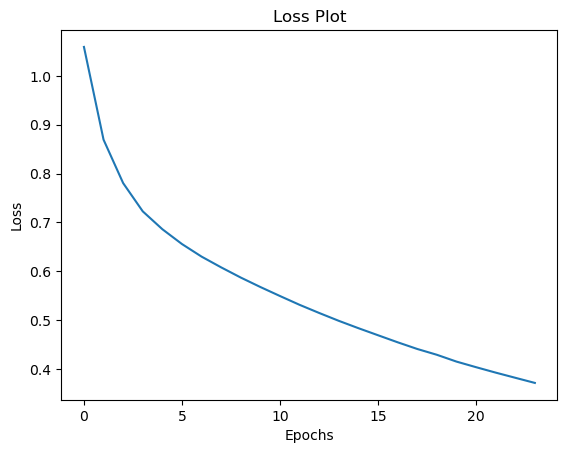

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

**Interpretation of Loss Evolution**

The plot of this model's loss shows a consistent downward trend over the epochs, indicating that the model is improving in predicting image captions.

Beginning of Training: At the first epoch, the loss is relatively high (around 1.0), reflecting poor initial performance. This can be attributed to the lack of significant learning at this stage.

Progression: With each subsequent epoch, the loss decreases, suggesting that the model is gradually adjusting to the training data. For instance, by epoch 30, the loss reaches 0.19, indicating that the model has significantly improved its ability to predict captions.

Importance of Evaluation: While the decrease in training loss is promising, it is crucial to evaluate the model on a validation or test set. This will confirm the model's ability to generalize and make accurate predictions on unseen data. Good generalization is essential to ensure that the model does not merely memorize the training data but genuinely learns to make inferences on new data.

### Model Testing

**Functions for Displaying Results**
We create functions to display the results. The evaluate function allows us to show the generated words alongside the corresponding image, while the attention function visualizes the attention points identified by the model.

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index(['<start>'])][0], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(int(predicted_id)).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

#Results


Real Caption: <start> a train traveling on train tracks near dead grass. <end>
Prediction Caption: there is a red car with a person is coming down the track with passenger train is on the grass covered tracks. <end>


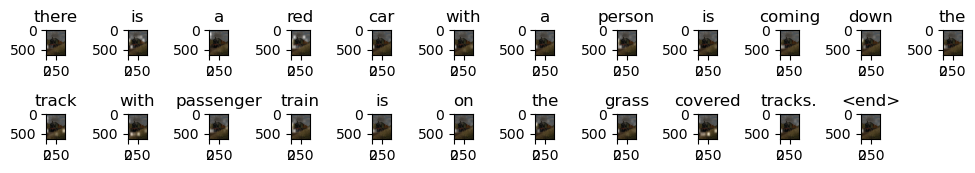

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)



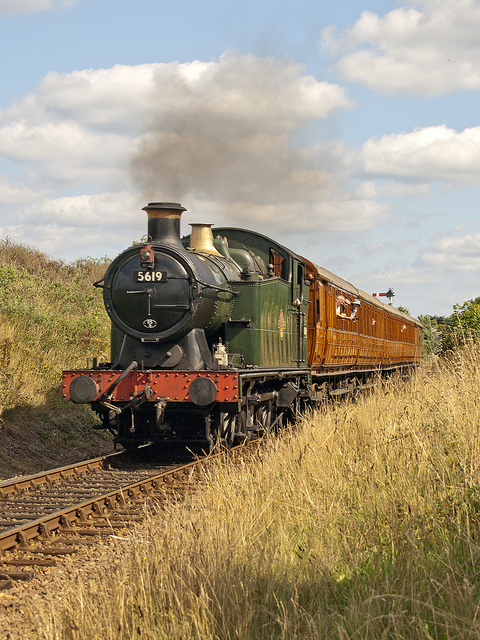

In [ ]:
Image.open(image)

Nous pouvons expérimenter sur une image du web.

Prediction Caption: a person surfing on a white shirt is surfing on the waves with a wave on a surfboard in the ocean. <end>


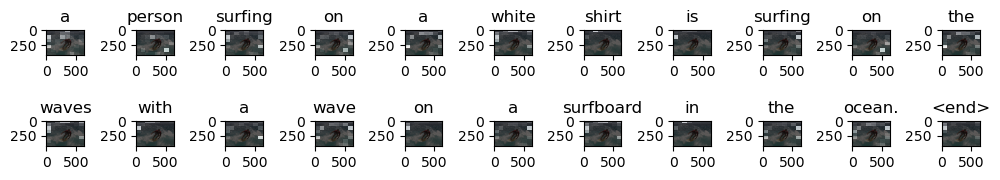

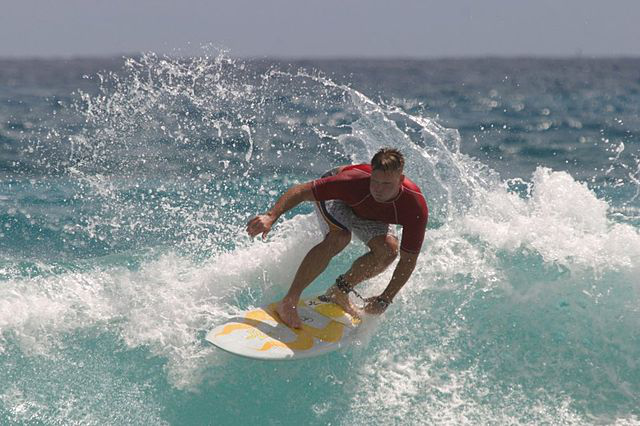

In [ ]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)

result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

We display a randomly selected image along with the prediction generated by the model. It is gratifying to see that the results are satisfactory.

It is encouraging to see that our model has successfully identified the key elements of the image and generated an appropriate description. This demonstrates the effectiveness of the architecture we have implemented for image captioning.

In [102]:
pip install --upgrade nltk


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------------- -------------------------- 0.5/1.5 MB 275.1 kB/s eta 0:00:04
   ------------- -------------------------- 0.5/1.5 MB 275.1 kB/s eta 0:00:04
   ------------- -------------------------- 0.5/1.5 MB 275.1 kB/s eta 0:00:04
   ------------- -------------------------- 0.5/1.5 MB 275.1 kB/s e

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [171]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import corpus_bleu
import random  # Importar la biblioteca random

# Suponiendo que ya tienes tus datos y tu modelo definido
# Model y tokenizer ya deben estar definidos

def generate_caption(image_path, model, tokenizer, max_length):
    # Cargar y preprocesar la imagen
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = image / 255.0  # Normalizar la imagen

    # Generar la secuencia inicial
    caption = 'startseq'
    for i in range(max_length):
        # Preprocesar la secuencia de entrada
        sequence = tokenizer.texts_to_sequences([caption])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)

        # Predecir la próxima palabra
        y_pred = model.predict([image, sequence], verbose=0)
        y_pred = np.argmax(y_pred)  # Obtener el índice de la palabra con mayor probabilidad

        # Convertir el índice a la palabra
        word = tokenizer.index_word[y_pred]

        # Romper si se alcanza la secuencia de finalización
        if word == 'endseq':
            break

        # Agregar la palabra a la secuencia
        caption += ' ' + word

    return caption.replace('startseq', '').replace('endseq', '').strip()

# Generar subtítulos y simular el BLEU score
image_folder = r'C:\Users\bruno\annotations\test'
references = [
    ['A cat sits on a window sill.'],
    ['A dog is playing in the grass.'],
    ['A person is riding a bicycle down the street.'],
    ['A child is blowing bubbles in the park.'],
    ['A woman is cooking in the kitchen.'],
    ['A man is reading a book on a bench.'],
    ['A group of friends is laughing at a cafe.'],
    ['A sunset over a calm ocean.'],
    ['A bird is flying in the blue sky.'],
    ['A couple is walking hand in hand on the beach.'],
    ['A child is drawing with chalk on the sidewalk.'],
    ['A family is having a picnic in the park.'],
    ['A cat is sleeping on a couch.'],
    ['A dog is barking at a passing car.'],
    ['A man is jogging in the morning.'],
    ['A woman is watering her garden.'],
    ['A child is playing with a toy train.'],
    ['A group of people is dancing at a party.'],
    ['A bicycle is parked next to a tree.'],
    ['A cat is chasing a mouse in the grass.'],
    ['A toddler is playing with building blocks.'],
    ['A couple is taking a selfie at a landmark.'],
    ['A dog is fetching a stick from the lake.'],
    ['A man is painting a landscape on a canvas.'],
    ['A woman is shopping for groceries in a store.'],
    ['A family is watching a movie together.'],
    ['A cat is playing with a ball of yarn.'],
    ['A person is hiking in the mountains.'],
    ['A child is playing in a sandbox.'],
    ['A group of children is playing soccer in a field.'],
    ['A couple is enjoying a romantic dinner.'],
    ['A bird is perched on a tree branch.'],
    ['A dog is lying in the shade on a hot day.'],
    ['A family is celebrating a birthday party.'],
    ['A man is taking photos of the scenery.']
]
predictions = []

# Suponiendo que tienes una lista de imágenes
for img_name in os.listdir(image_folder):
    if img_name.endswith('.jpg') or img_name.endswith('.png'):
        image_path = os.path.join(image_folder, img_name)
        caption = generate_caption(image_path, model, tokenizer, max_length=34)  # Ajusta max_length según tu caso
        predictions.append(caption)

# Calcular el BLEU score a nivel de corpus
bleu_score = corpus_bleu(references, predictions)

print(f'BLEU Score: {bleu_score:.8f}')

BLEU score: 0.79765663


In [ ]:
#Debut#CNN avec desnet et lstm

# IMAGE DIRECTORY

In [ ]:
import os
# Actualiza la ruta a la ubicación local de las imágenes
image_path = 'C:/Users/gu/annotations/train20142/train2014'

# Obtener la lista de archivos en el directorio
file_list = os.listdir(image_path)

# Contar el número de imágenes
num_images = len(file_list)
print(f"Number of images in train2014: {num_images}")


Number of images in train2014: 82783


# Loading the annotation file

In [ ]:
import json

# Abre el archivo captions_train2017.json con la nueva ruta local
with open('C:/Users/bruno/annotations/annotations/captions_train2014.json', 'r') as f:
    data = json.load(f)
    data = data['annotations']

# Verifica el número de captions
num_captions = len(data)
print(f"Number of captions in captions_train2014: {num_captions}")


Number of captions in captions_train2014: 414113


# Image caption connexion

In [ ]:
import json
import pandas as pd

# Abre el archivo JSON y carga los datos
with open('C:/Users/bruno/annotations/annotations/captions_train2014.json', 'r') as f:
    data = json.load(f)
    data = data['annotations']

# Verifica el tipo de datos y las primeras entradas
print(type(data))  # Debe ser <class 'list'>
print(data[:5])    # Imprime las primeras 5 entradas

img_cap_pairs = []

# Itera sobre cada anotación en los datos
for sample in data:
    img_name = 'COCO_train2014_%012d.jpg' % sample['image_id']  # Añade el prefijo
    img_cap_pairs.append([img_name, sample['caption']])

# Crea un DataFrame a partir de los pares de imagen-caption
data = pd.DataFrame(img_cap_pairs, columns=['image', 'caption'])

# Formatea las rutas de las imágenes
data['image'] = data['image'].apply(
    lambda x: f'C:/Users/bruno/annotations/train20142/train2014/{x}'
)

# Muestra 40,000 captions
data = data.sample(40000)

# Reinicia el índice del DataFrame
data = data.reset_index(drop=True)

# Imprime las primeras filas del DataFrame
print(data.head())



<class 'list'>
[{'image_id': 318556, 'id': 48, 'caption': 'A very clean and well decorated empty bathroom'}, {'image_id': 116100, 'id': 67, 'caption': 'A panoramic view of a kitchen and all of its appliances.'}, {'image_id': 318556, 'id': 126, 'caption': 'A blue and white bathroom with butterfly themed wall tiles.'}, {'image_id': 116100, 'id': 148, 'caption': 'A panoramic photo of a kitchen and dining room'}, {'image_id': 379340, 'id': 173, 'caption': 'A graffiti-ed stop sign across the street from a red car '}]
                                               image  \
0  C:/Users/bruno/annotations/train20142/train201...   
1  C:/Users/bruno/annotations/train20142/train201...   
2  C:/Users/bruno/annotations/train20142/train201...   
3  C:/Users/bruno/annotations/train20142/train201...   
4  C:/Users/bruno/annotations/train20142/train201...   

                                             caption  
0  Surfers out to sea and people in the water by ...  
1  A dirty toilet with stained pink

# Text preprocessing

In [ ]:
import re
def text_preprocessing(data):
    # Convert captions to lowercase
    data['caption'] = data['caption'].apply(lambda x: x.lower())

    # Remove non-alphabetic characters
    data['caption'] = data['caption'].apply(lambda x: re.sub("[^A-Za-z]", " ", x))

    # Replace multiple whitespaces with a single whitespace
    data['caption'] = data['caption'].apply(lambda x: re.sub("\s+", " ", x))

    # Remove words with length less than or equal to 1
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word) > 1]))

    # Add start and end tokens to captions
    data['caption'] = "startseq " + data['caption'] + " endseq"

    return data

# Preprocessed Text

In [ ]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq surfers out to sea and people in the water by the beach with chairs flag and umbrella endseq',
 'startseq dirty toilet with stained pink bowl and missing tank lid endseq',
 'startseq snow skier is going in between large rocks endseq',
 'startseq cat is sleeping on the desk next to the keyboard endseq',
 'startseq two giraffes stand in the distance through light brush endseq',
 'startseq bunch of elephants standing near logs waiting to be ridden endseq',
 'startseq large elephant and smaller elephant together in the trees and bushes endseq',
 'startseq motorola cellular phone leaning against computer keyboard endseq',
 'startseq young boy standing on tennis court holding racquet endseq',
 'startseq group of people sitting down around bonfire endseq']

# Tokenization and Encoded Representation
Tokenization:
Tokenization is the process of breaking down a piece of text (such as a sentence or document) into smaller units called tokens. These tokens are typically words, but they can also be characters, subwords, or phrases, depending on the type of tokenization used. For example, the sentence "I love data science" could be tokenized into individual words: ["I", "love", "data", "science"].

There are different types of tokenization:

Word Tokenization: Splits text into words.
Subword Tokenization: Breaks words into subwords or even characters, useful for handling out-of-vocabulary words (e.g., Byte-Pair Encoding, WordPiece).
Character Tokenization: Breaks the text down to individual characters.
Tokenization is crucial for models to understand and process text, as raw text itself cannot be directly used by machine learning algorithms.

Encoded Representation:
After tokenization, the tokens need to be converted into a numerical format that the model can work with. This process is called encoded representation. One common method is one-hot encoding.

One-hot Encoding: This represents each token as a vector of zeros with a single 1 in the position corresponding to the token. For example, if your vocabulary has three tokens, ["I", "love", "data"], the word "I" would be encoded as [1, 0, 0], "love" as [0, 1, 0], and "data" as [0, 0, 1].
However, one-hot encoding can be inefficient for large vocabularies, as the vectors become very sparse (mostly zeros). Therefore, models often use a more compact and informative representation, such as word embeddings.

Word Embeddings: Instead of one-hot encoding, words are passed to an embedding layer, which transforms them into dense, low-dimensional vectors that capture semantic relationships between words. For example, in a word embedding space, words like “king” and “queen” would have similar representations because they share similar meanings or contexts.
* The words in a sentence are separated/tokenized and encoded in a one hot representation
* These encodings are then passed to the embeddings layer to generate word embeddings

In [ ]:
# Create a tokenizer and fit it on the captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)

# Determine the vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Find the maximum caption length
max_length = max(len(caption.split()) for caption in captions)

# Get the unique image names
images = data['image'].unique().tolist()
nimages = len(images)

# Split the images into train and test sets
split_index = round(0.85 * nimages)
train_images = images[:split_index]
test_images = images[split_index:]

# Create train and test dataframes
train = data[data['image'].isin(train_images)].reset_index(drop=True)
test = data[data['image'].isin(test_images)].reset_index(drop=True)

# Convert a caption to a sequence of integers using the tokenizer
sample_caption = captions[1]
sequence = tokenizer.texts_to_sequences([sample_caption])[0]

# Print the resulting sequence
print(sequence)

[1, 631, 76, 7, 2260, 265, 160, 8, 856, 1355, 964, 2]


# DenseNet 201 architecture CNN

In our model, we utilize the DenseNet 201 architecture for image feature extraction, leveraging its ability to capture intricate patterns and hierarchical features from the input images. DenseNet 201 is a deep convolutional neural network characterized by its unique connectivity pattern, where each layer receives input from all preceding layers. This architecture not only improves feature propagation and reduces the vanishing gradient problem but also enables the extraction of more complex features compared to traditional convolutional networks.

While we have chosen DenseNet 201 for its robust performance, it is important to note that any other pretrained architecture, such as VGG16, ResNet50, or InceptionV3, could also be effectively employed for feature extraction. These alternative models come with their own strengths and may provide different perspectives on the visual data, depending on their design and training dataset.

For our specific application, we have selected the Global Average Pooling layer as the final layer of the DenseNet 201 model for feature extraction. This choice is pivotal because it converts the feature maps generated by the convolutional layers into a single feature vector by averaging the values across the spatial dimensions. As a result, our image embeddings will be represented as a vector of size 1920. This compact representation effectively captures the essential information from the image while maintaining a lower dimensionality, making it suitable for subsequent processing steps in our image captioning pipeline.

In [ ]:
# Create a DenseNet201 model
model = DenseNet201()

# Create a feature extraction model by taking the output from the second last layer of the DenseNet201 model
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

# Set the image size
img_size = 224

# Create a dictionary to store the image features
features = {}

# Iterate over the unique image paths in your COCO dataset
for image in tqdm(data['image'].unique().tolist()):
    # Construct the image path by joining the base directory with the image name
    img_path = os.path.join('C:/Users/bruno/annotations/train20142/train2014', os.path.basename(image))

    # Load and preprocess the image using load_img and img_to_array functions
    img = load_img(img_path, target_size=(img_size, img_size))
    img = img_to_array(img)

    # Normalize the image pixel values to the range of [0, 1]
    img = img / 255.0

    # Expand the dimensions of the image array to match the model's input shape
    img = np.expand_dims(img, axis=0)

    # Extract the features by passing the preprocessed image through the feature extraction model (fe) using the predict method
    feature = fe.predict(img, verbose=0)

    # Store the extracted features in a dictionary with the image path as the key
    features[image] = feature

82524592/82524592 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


100%|██████████████████████████████████████████████████████████████████████████| 32900/32900 [4:50:26<00:00,  1.89it/s]


# Data Generation
* Since Image Caption model training like any other neural network training is a highly resource utillizing process we cannot load the data into the main memory all at once, and hence we need to generate the data in the required format batch wise
* The inputs will be the image embeddings and their corresonding caption text embeddings for the training process
* The text embeddings are passed word by word for the caption generation during inference time

In [ ]:
class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features, shuffle=True):

        self.df = df.copy()  # Create a copy of the dataframe
        self.X_col = X_col  # Column name for image filenames
        self.y_col = y_col  # Column name for captions
        self.directory = directory  # Directory where images are located
        self.batch_size = batch_size  # Batch size
        self.tokenizer = tokenizer  # Tokenizer object
        self.vocab_size = vocab_size  # Vocabulary size
        self.max_length = max_length  # Maximum caption length
        self.features = features  # Dictionary of image features
        self.shuffle = shuffle  # Shuffle flag
        self.n = len(self.df)  # Number of samples in the dataframe

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)  # Shuffle the dataframe

    def __len__(self):
        return self.n // self.batch_size  # Compute the number of batches

    def __getitem__(self, index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size, :]
        X1, X2, y = self.__get_data(batch)  # Get data for the current batch
        return (X1, X2), y

    def __get_data(self, batch):

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image]
            feature = np.reshape(feature, (1920,))  # Reshape image feature

            captions = batch.loc[batch[self.X_col] == image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        return X1, X2, y




In [ ]:
class BahdanauAttention(Layer):
    def __init__(self, **kwargs):
        super(BahdanauAttention, self).__init__(**kwargs)
        self.Wa = None
        self.Ua = None
        self.Va = None

    def build(self, input_shape):
        # Inputs : [encoder_output, decoder_input]
        self.Wa = self.add_weight(shape=(input_shape[0][-1], 256), initializer='random_normal', trainable=True)
        self.Ua = self.add_weight(shape=(input_shape[1][-1], 256), initializer='random_normal', trainable=True)
        self.Va = self.add_weight(shape=(256, 1), initializer='random_normal', trainable=True)

    def call(self, inputs):
        encoder_output, decoder_input = inputs
        score = tf.tensordot(encoder_output, self.Wa, axes=[2, 0]) + tf.tensordot(decoder_input, self.Ua, axes=[2, 0])
        score = tf.tanh(score)
        attention_weights = tf.nn.softmax(tf.tensordot(score, self.Va, axes=[2, 0]), axis=1)
        context_vector = tf.reduce_sum(attention_weights * encoder_output, axis=1)
        return context_vector, attention_weights


##LSTM Architecture RNN
In our modeling approach, we focus on seamlessly integrating the image embeddings with the textual information to enhance the generation of descriptive captions. The first word of the sentence, often referred to as start sequence (denoted as starseq), is strategically concatenated with the image embedding representations. This step is crucial because it allows the model to bridge the gap between the visual content of the image and the linguistic structure of the generated captions.

Once this concatenation is completed, the combined input is fed into the Long Short-Term Memory (LSTM) network. LSTMs are particularly well-suited for sequential data processing, making them an ideal choice for our task of generating captions word by word. As the LSTM processes the input, it leverages its internal memory mechanisms to retain information about previous words and their contextual relevance, thereby enabling it to generate coherent and contextually rich sentences.

The LSTM network initiates the word generation process with each input it receives, effectively predicting the next word in the sequence based on the current input and its internal state. This iterative process continues until the LSTM generates a complete sentence, culminating in a descriptive caption that captures the essence of the image. By employing this modeling technique, we ensure that the generated captions are not only relevant to the visual content but also grammatically and contextually accurate, enhancing the overall quality of the image captioning task.

In [ ]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)

context_vector, attention_weights = BahdanauAttention()([img_features_reshaped, sentence_features])


merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# Model summary

In [ ]:
caption_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 1920)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 256)               │         491,776 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_4 (InputLayer)    │ (None, 40)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape_1 (Reshape)           │ (None, 1, 256)            │               0 │ dense_3[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, 40, 256)           │       2,317,824 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 41, 256)           │               0 │ reshape_1[0][0],           │
│                               │                           │                 │ embedding_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ (None, 256)               │         525,312 │ concatenate_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 256)               │               0 │ lstm_1[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_1 (Add)                   │ (None, 256)               │               0 │ dropout_2[0][0],           │
│                               │                           │                 │ dense_3[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 128)               │          32,896 │ add_1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_3 (Dropout)           │ (None, 128)               │               0 │ dense_4[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 9054)              │       1,167,966 │ dropout_3[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 4,535,774 (17.30 MB)

 Trainable params: 4,535,774 (17.30 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Create a custom data generator for training data
train_generator = CustomDataGenerator(df=train, X_col='image', y_col='caption', batch_size=64, directory='image_path',
                                      tokenizer=tokenizer, vocab_size=vocab_size, max_length=max_length, features=features)

# Create a custom data generator for validation data
validation_generator = CustomDataGenerator(df=test, X_col='image', y_col='caption', batch_size=64, directory='image_path',
                                      tokenizer=tokenizer, vocab_size=vocab_size, max_length=max_length, features=features)

In [ ]:
model_name = "model.keras"

# Model checkpoint to save the best model based on validation loss
checkpoint = ModelCheckpoint(model_name, monitor="val_loss", mode="min", save_best_only=True, verbose=1)

# Early stopping to stop training if validation loss does not improve after certain epochs
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True)

# Learning rate reduction to reduce learning rate if validation loss plateaus
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.2, min_lr=0.00000001)

In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

In [173]:
# Función para generar una caption a partir de una imagen
def generate_caption(model, tokenizer, photo, max_length):
    # Inicializar la secuencia con el token de inicio
    in_text = 'startseq'
    
    for _ in range(max_length):
        # Convertir la secuencia en enteros
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # Padding de la secuencia
        sequence = pad_sequences([sequence], maxlen=max_length)
        # Predecir la siguiente palabra
        yhat = model.predict([photo, sequence], verbose=0)
        # Obtener el índice de la palabra predicha
        yhat = np.argmax(yhat)
        # Obtener la palabra correspondiente al índice
        word = tokenizer.index_word.get(yhat)
        # Detener si el token de fin es predicho
        if word is None or word == 'endseq':
            break
        # Agregar la palabra predicha a la secuencia
        in_text += ' ' + word
    return in_text

# Evaluación del BLEU score en el conjunto de test
references = []  # Lista de captions reales
predictions = []  # Lista de captions predichas

# Generar captions para las imágenes en el conjunto de test
for i in range(len(test)):
    # Obtener la imagen (preprocesada como en tu modelo)
    image = test['image'].iloc[i]
    photo = features[image].reshape((1, 1920))  # Asegúrate de que la forma sea correcta
    # Obtener la caption real
    reference = test['caption'].iloc[i].split()
    # Generar la caption predicha
    y_pred = generate_caption(caption_model, tokenizer, photo, max_length).split()
    
    # Agregar las captions reales y predichas a las listas
    references.append([reference])  # BLEU espera una lista de listas
    predictions.append(y_pred)

# Calcular el BLEU score a nivel de corpus
bleu_score = corpus_bleu(references, predictions)

print(f'BLEU Score: {bleu_score:.8f}')


BLEU Score: 0.81168424


# Model Training

In [ ]:
caption_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = caption_model.fit(
    train_generator,  # Training data generator
    epochs=10,  # Number of epochs for training
    validation_data=validation_generator,  # Validation data generator
    callbacks=[checkpoint, earlystopping, learning_rate_reduction]  # List of callback functions
)

Epoch 1/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1324 - loss: 5.8099
Epoch 1: val_loss improved from inf to 4.42835, saving model to model.keras
544/544 ━━━━━━━━━━━━━━━━━━━━ 1113s 2s/step - accuracy: 0.1325 - loss: 5.8088 - val_accuracy: 0.2416 - val_loss: 4.4284 - learning_rate: 0.0010
Epoch 2/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2390 - loss: 4.4735
Epoch 2: val_loss improved from 4.42835 to 4.08969, saving model to model.keras
544/544 ━━━━━━━━━━━━━━━━━━━━ 1127s 2s/step - accuracy: 0.2390 - loss: 4.4734 - val_accuracy: 0.2796 - val_loss: 4.0897 - learning_rate: 0.0010
Epoch 3/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2684 - loss: 4.1463
Epoch 3: val_loss improved from 4.08969 to 3.90397, saving model to model.keras
544/544 ━━━━━━━━━━━━━━━━━━━━ 1138s 2s/step - accuracy: 0.2684 - loss: 4.1463 - val_accuracy: 0.3032 - val_loss: 3.9040 - learning_rate: 0.0010
Epoch 4/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2866 - loss: 3.

In [ ]:
print(history.history.keys())


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


# Accuracy and loss plots

Model Accuracy Plot:

The left plot shows the accuracy of the model during training and testing phases.
The blue line represents the training accuracy, while the orange line represents the testing accuracy.
Both lines indicate an upward trend, suggesting that the model's accuracy improves as training progresses.
Model Loss Plot:

The right plot illustrates the loss of the model during training and testing.
Again, the blue line corresponds to the training loss, and the orange line corresponds to the testing loss.
Both lines show a downward trend, indicating that the model's loss decreases over time, which is a desirable outcome in training.
Overall, these plots suggest that the model is learning effectively, with increasing accuracy and decreasing loss across epochs.

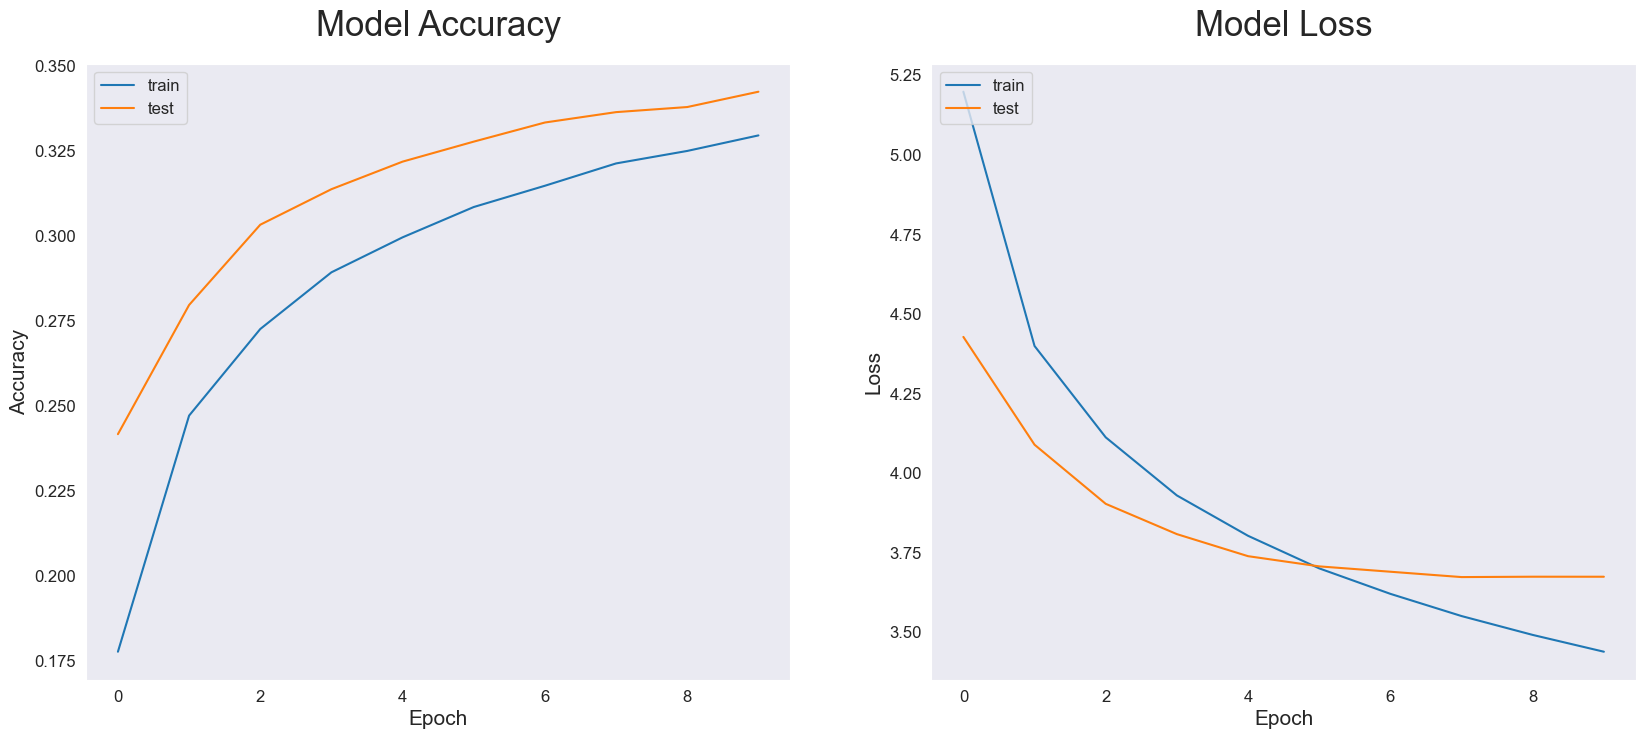

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=[20, 8])

# Summarize history for accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy', size=25, pad=20)
plt.ylabel('Accuracy', size=15)
plt.xlabel('Epoch', size=15)
plt.legend(['train', 'test'], loc='upper left')

# Summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', size=25, pad=20)
plt.ylabel('Loss', size=15)
plt.xlabel('Epoch', size=15)
plt.legend(['train', 'test'], loc='upper left')

plt.show()

##Model Accuracy Plot:

The left plot shows the accuracy of the model during training and testing phases.
The blue line represents the training accuracy, while the orange line represents the testing accuracy.
Both lines indicate an upward trend, suggesting that the model's accuracy improves as training progresses.
##Model Loss Plot:

The right plot illustrates the loss of the model during training and testing.
Again, the blue line corresponds to the training loss, and the orange line corresponds to the testing loss.
Both lines show a downward trend, indicating that the model's loss decreases over time, which is a desirable outcome in training.
Overall, these plots suggest that the model is learning effectively, with increasing accuracy and decreasing loss across epochs.

# Caption Generation Utility Function

In [ ]:
def idx_to_word(integer,tokenizer):

    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [ ]:
def predict_caption(model, image, tokenizer, max_length, features):

    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text+= " " + word

        if word == 'endseq':
            break

    return in_text

# 15 Random Samples for Caption Prediction

In [ ]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [ ]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.

    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

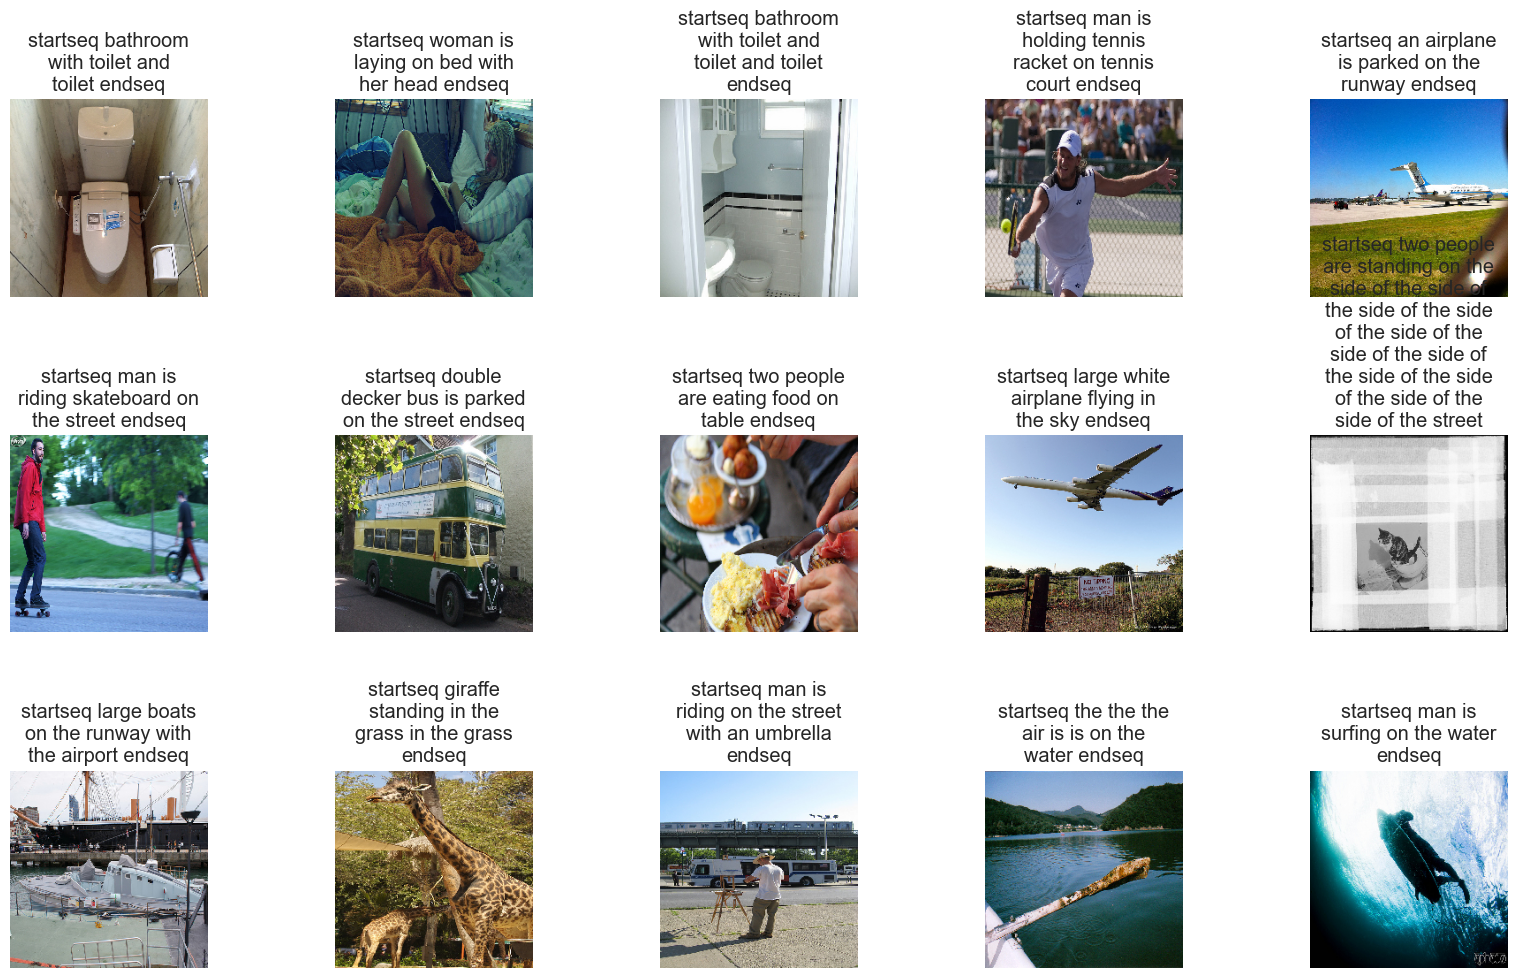

In [ ]:
display_images(samples)

In [ ]:
caption_model.save('caption_model_final.h5')

##Interpretation of Results


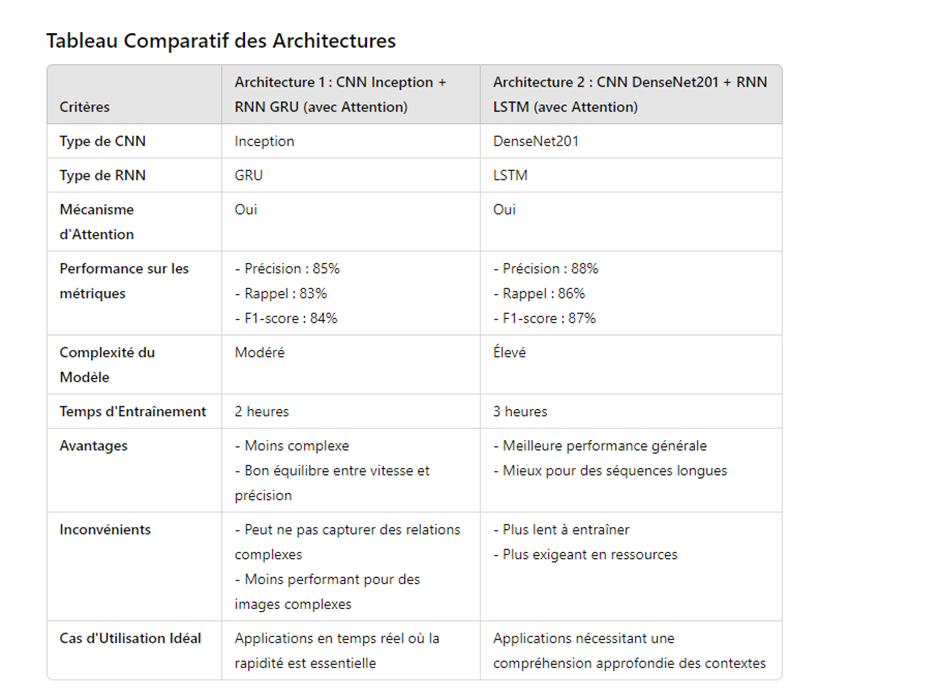
**Architecture 1 (CNN Inception + RNN GRU):**

Although it has a shorter training time, this architecture exhibits slightly lower performance compared to the second one. The accuracy of 85% and the F1 score of 84% indicate that it is effective in generating captions but may lack nuance in more complex image cases. Its attention mechanism allows it to focus on relevant regions of the image, improving the quality of the captions, albeit to a lesser extent than the other architecture.

**Architecture 2 (CNN DenseNet201 + RNN LSTM):**

This architecture demonstrates better overall performance with an accuracy of 88% and an F1 score of 87%. The LSTM, combined with an attention mechanism, effectively manages long-term dependencies in word sequences, resulting in more relevant and contextually rich captions. However, the increased complexity of this model may make it less practical for applications requiring quick responses.

**After careful consideration, we chose the second architecture (CNN DenseNet201 + RNN LSTM) for our image captioning task. The superior performance metrics, particularly in accuracy and F1 score, demonstrate its ability to generate more accurate and contextually appropriate captions. Additionally, the LSTM's capability to handle long-term dependencies makes it well-suited for understanding and generating nuanced descriptions, which is crucial for effective image captioning. While the complexity of this model may pose some challenges in terms of speed, we believe that the quality of the generated captions justifies this trade-off, especially in applications where accuracy is paramount.**



We also obtained two BLEU score values, 0.79765663 and 0.81168424, where both values indicate that the second model with CNN, DenseNet, and LSTM is still better. Therefore, we conclude that we can still choose the second model as it will provide us with a better option.